# Axis info metadata EDA

## Notebook set-up

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


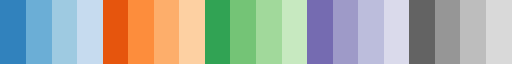

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Local imports
import configuration as config

# Make sure the figures directory exists for saving plots
figures_dir = f'{config.FIGURES_DIRECTORY}/EDA'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

config.COLORMAP

## 1. Load and inspect

In [2]:
# Load the axis info metadata from parquet file
axis_info = pd.read_parquet(f'{config.DATA_DIRECTORY}/raw/axis_info.parquet')
axis_info.head()

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h
0,0.000028,4.078463,0.1,0.000028
1,0.000056,4.074023,4.5,0.000056
2,0.001361,4.069568,0.1,0.000139
3,0.001389,4.065100,4.5,0.000167
4,0.002694,4.060618,0.1,0.000250


In [3]:
# Get statistical summary of the axis info data
axis_info.describe()

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h
count,11250.000000,356.000000,11250.000000,135000.000000
mean,3.749375,3.000661,2.300000,3.749986
std,2.165160,0.711864,2.200098,2.165072
min,0.000028,1.633253,0.100000,0.000028
25%,1.874701,2.407917,0.100000,1.875007
50%,3.749375,3.073674,2.300000,3.749986
75%,5.624049,3.630522,4.500000,5.624965
max,7.498722,4.078463,4.500000,7.499944


In [4]:
# Check data types and structure of the axis info
axis_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135000 entries, 0 to 134999
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   AIRS-CH0-axis0-h           11250 non-null   float64
 1   AIRS-CH0-axis2-um          356 non-null     float64
 2   AIRS-CH0-integration_time  11250 non-null   float64
 3   FGS1-axis0-h               135000 non-null  float64
dtypes: float64(4)
memory usage: 4.1 MB


Ah - OK, this makes more sense now. When I saw 'axis', I was thinking of spatial alignment of the satellite, or maybe the star system? I don't know what I was picturing, but this is better. It's data for each axis of the signal matrices. Much more helpful. Here's my interpretation:

1. AIRS-CH0-axis0-h: Time index for AIRS readings - h is probably hours (0.000028 x 3600 sec per hour ~ 0.1 s)
2. AIRS-CH0-axis2-um: Wavelength across the frames in μm, the range of ~ 1.6 - μm is consistent with the high energy-ish end of the IR spectrum
3. AIRS-CH0-integration_time: Amount of time the detector had been accumulating for when read, presumably seconds
4. FGS1-axis0-h: Time index of FGS1 readings

Let's add the capture times in seconds to make it easer to look at.

In [5]:
# Convert time from hours to seconds for easier interpretation
axis_info['FGS1-axis0-s'] = axis_info['FGS1-axis0-h'] * 3600
axis_info['AIRS-CH0-axis0-s'] = axis_info['AIRS-CH0-axis0-h'] * 3600

## 2. Exposure time series

### 2.1. Load the frames

In [6]:
# Load AIRS-CH0 signal data and reshape to 3D array (frames, rows, cols)
airs_file = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}/AIRS-CH0_signal_0.parquet'
airs_frames = pd.read_parquet(airs_file).to_numpy().reshape(11250, 32, 356).astype(np.float64)

# Load FGS1 signal data and reshape to 3D array (frames, rows, cols)
fgs_file = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}/FGS1_signal_0.parquet'
fgs_frames = pd.read_parquet(fgs_file).to_numpy().reshape(135000, 32, 32).astype(np.float64)

### 2.2. Plot

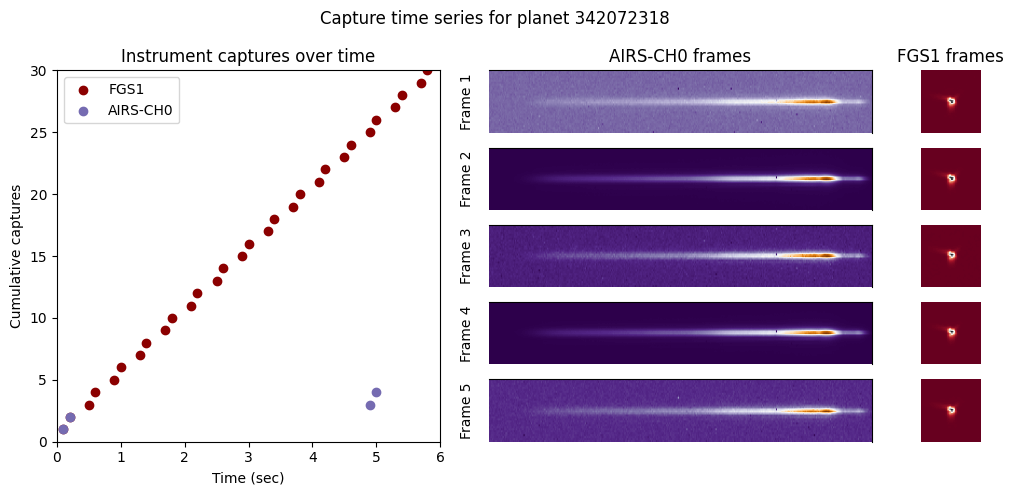

In [7]:
# Create comprehensive visualization of capture timing and frame data
fig = plt.figure(figsize=(10, 5))
fig.suptitle(f'Capture time series for planet {config.SAMPLE_PLANET}')

# Create grid layout for subplots
gs = fig.add_gridspec(5,9)

# Left panel: timeline of instrument captures
ax1 = fig.add_subplot(gs[:5, :4])
ax1.set_title('Instrument captures over time')

# Plot FGS1 capture times as scatter points
ax1.scatter(
    axis_info['FGS1-axis0-h'] * 3600,
    list(range(1, len(axis_info['FGS1-axis0-h']) + 1)),
    label='FGS1',
    color='darkred'
)

# Plot AIRS-CH0 capture times as scatter points
ax1.scatter(
    axis_info['AIRS-CH0-axis0-h'] * 3600,
    list(range(1, len(axis_info['AIRS-CH0-axis0-h']) + 1)),
    label='AIRS-CH0',
    color=config.SPECTRUM_COLOR
)

# Set axis limits and labels for the timeline plot
ax1.set_xlim(0, 6)
ax1.set_ylim(0, 30)
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Cumulative captures')
ax1.legend(loc='best')

# Initialize lists to store subplot axes for frame displays
airs_axs = []
fgs_axs = []

# Create 5 rows of frame displays (AIRS and FGS side by side)
for i in range(5):

    # Create subplot for AIRS-CH0 frame
    airs_axs.append(fig.add_subplot(gs[i, 4:8]))

    # Create subplot for FGS1 frame
    fgs_axs.append(fig.add_subplot(gs[i, 8:]))

    # Display AIRS-CH0 frame as heatmap
    airs_axs[i].imshow(airs_frames[i], aspect='auto', cmap=config.AIRS_HEATMAP_CMAP)
    airs_axs[i].set_ylabel(f'Frame {i+1}')

    # Remove axis decorations for cleaner display
    airs_axs[i].spines['left'].set_visible(False)    # Hide the left spine (axis line)
    airs_axs[i].yaxis.set_ticks_position('none')     # Remove y-axis tick marks
    airs_axs[i].set_yticklabels([])                  # Remove y-axis tick labels
    airs_axs[i].spines['bottom'].set_visible(False)  # Hide the bottom spine (axis line)
    airs_axs[i].xaxis.set_ticks_position('none')     # Remove x-axis tick marks
    airs_axs[i].set_xticklabels([])                  # Remove x-axis tick labels

    # Display FGS1 frame as heatmap with different colormap
    fgs_axs[i].imshow(fgs_frames[i], aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
    fgs_axs[i].axis('off')  # Turn off all axis elements

# Add titles to the top row of frame displays
airs_axs[0].set_title('AIRS-CH0 frames')
fgs_axs[0].set_title('FGS1 frames')

fig.tight_layout()

# Save the complete visualization
plt.savefig(
    f'{figures_dir}/01.5.1-captures_over_time.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

In [8]:
# Display first 5 rows of axis info with time conversions
axis_info.head(5)

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h,FGS1-axis0-s,AIRS-CH0-axis0-s
0,0.000028,4.078463,0.1,0.000028,0.1,0.1
1,0.000056,4.074023,4.5,0.000056,0.2,0.2
2,0.001361,4.069568,0.1,0.000139,0.5,4.9
3,0.001389,4.065100,4.5,0.000167,0.6,5.0
4,0.002694,4.060618,0.1,0.000250,0.9,9.7


### 2.3. AIRS-CH0 total signal per frame

In [9]:
# Calculate total signal (sum of all pixels) for each AIRS-CH0 frame
airs_sums = np.sum(airs_frames, axis=(1,2))

# Print total flux for first 5 frames to examine signal levels
for i, airs_sum in enumerate(airs_sums[:5]):
    print(f'AIRS-CH0 frame {i}, total flux: {airs_sum:.2e}')

AIRS-CH0 frame 0, total flux: 5.14e+06
AIRS-CH0 frame 1, total flux: 1.29e+07
AIRS-CH0 frame 2, total flux: 5.14e+06
AIRS-CH0 frame 3, total flux: 1.29e+07
AIRS-CH0 frame 4, total flux: 5.14e+06


### 2.4. FGS1 total signal per frame

In [10]:
# Calculate total signal (sum of all pixels) for each FGS1 frame
fgs_sums = np.sum(fgs_frames, axis=(1,2))

# Print total flux for first 5 frames to examine signal levels
for i, fgs_sum in enumerate(fgs_sums[:5]):
    print(f'FGS1 frame {i}, total flux: {fgs_sum:.2e}')

FGS1 frame 0, total flux: 5.44e+05
FGS1 frame 1, total flux: 6.40e+05
FGS1 frame 2, total flux: 5.43e+05
FGS1 frame 3, total flux: 6.41e+05
FGS1 frame 4, total flux: 5.44e+05


You can clearly see the correlated double sampling exposure pairs for each instrument.

The first real exposure for both instruments therefore starts at t=0 ends at t=0.1 seconds. After the sensors are read at t=0.1, both instruments start their second exposure after a 0.1 second delay at t=0.2. AIRS-CH0 accumulates for 4.5 seconds, reads at t=4.7, and after a 0.1 second delay, starts the exposure that will be read at t=4.9 at t=4.8. FGS1 follows the same cadence, but with a long exposure time of 0.1 seconds instead of 4.5 seconds.

The [description of CDS](https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data?scriptVersionId=247643997&cellId=25) given in the [preprocessing notebook](https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data) says to subtract the sub exposures. Though the description of which order to subtract them in seems to contradict the description given in the [dataset description](https://www.kaggle.com/competitions/ariel-data-challenge-2025/data). The short answer is, subtract the first frame from second and so on, because it has lower total signal.

That data preprocessing notebook from the competition organizers also recommends a crop for the AIRS-CH0 data to make the pixels match the wavelength indexes. Let's do that now.

In [11]:
# Crop AIRS-CH0 frames to match wavelength indices (remove unused columns)
cut_inf, cut_sup = 39, 321
airs_frames = airs_frames[:, :, cut_inf:cut_sup]

# Print resulting frame shapes after cropping
print(f'AIRS-CH0 frames shape: {airs_frames.shape}')
print(f'FGS1 frames shape: {fgs_frames.shape}')

AIRS-CH0 frames shape: (11250, 32, 282)
FGS1 frames shape: (135000, 32, 32)


## 3. CDS sub-exposure subtraction

In [12]:
# Function to perform Correlated Double Sampling (CDS)
# Subtracts first exposure from second exposure in each pair
def get_cds(frames):

    return np.subtract(frames[1::2,:,:], frames[::2,:,:])

In [13]:
# Apply CDS processing to both instrument datasets
airs_cds_frames = get_cds(airs_frames)
fgs_cds_frames = get_cds(fgs_frames)

# Check resulting shapes - should have half the number of frames
print(f'AIRS-CH9 CDS frames shape: {airs_cds_frames.shape}')
print(f'FGS1 CDS frames shape: {fgs_cds_frames.shape}')

AIRS-CH9 CDS frames shape: (5625, 32, 282)
FGS1 CDS frames shape: (67500, 32, 32)


So far so good - we have exactly half as many frames for both instruments, but the individual frame shapes have not changed.

### 3.1. Sanity check

In [14]:
# Verify CDS subtraction is working correctly for AIRS-CH0
# Check that frame 1 - frame 0 equals our CDS result
print(f'    AIRS-CH0 frame 0 sum: {np.sum(airs_frames[0])}')
print(f'    AIRS-CH0 frame 1 sum: {np.sum(airs_frames[1])}')
print(f'AIRS-CH0 CDS frame 0 sum: {np.sum(airs_cds_frames[1])}')

    AIRS-CH0 frame 0 sum: 4098521.0
    AIRS-CH0 frame 1 sum: 11263539.0
AIRS-CH0 CDS frame 0 sum: 7167123.0


In [15]:
# Verify CDS subtraction is working correctly for FGS1
# Check that frame 1 - frame 0 equals our CDS result
print(f'    FGS1 frame 0 sum: {np.sum(fgs_frames[0])}')
print(f'    FGS1 frame 1 sum: {np.sum(fgs_frames[1])}')
print(f'FGS1 CDS frame 0 sum: {np.sum(fgs_cds_frames[0])}')

    FGS1 frame 0 sum: 544148.0
    FGS1 frame 1 sum: 640262.0
FGS1 CDS frame 0 sum: 96114.0


And it looks like we have positive values in both the AIRS and FGS signals, which is a good sign that we are subtracting correctly.

## 4. AIRS-CH0 sample CDS frames

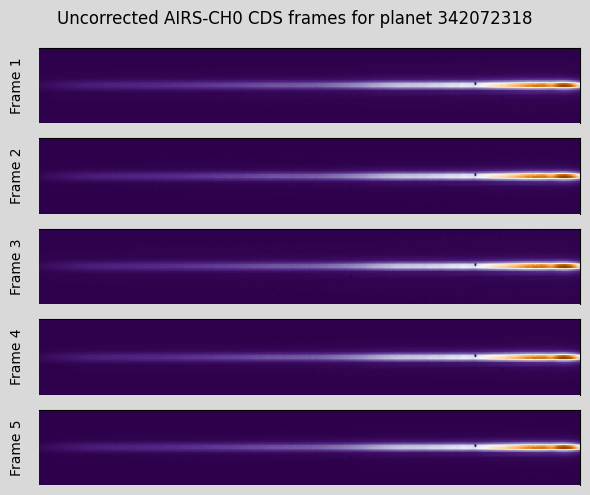

In [16]:
# Plot the first few CDS-processed AIRS-CH0 frames
n_frames = 5
fig, axs = plt.subplots(n_frames, 1, figsize=(config.STD_FIG_WIDTH, n_frames))
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)
axs = axs.flatten()

fig.suptitle(f'Uncorrected AIRS-CH0 CDS frames for planet {config.SAMPLE_PLANET}')

# Display each frame as a heatmap
for i in range(n_frames):
    frame = airs_cds_frames[i]        
    im = axs[i].imshow(frame, aspect='auto', cmap=config.AIRS_HEATMAP_CMAP)
    axs[i].set_ylabel(f'Frame {i+1}')

    # Remove axis decorations for cleaner appearance
    axs[i].spines['left'].set_visible(False)    # Hide the left spine (axis line)
    axs[i].yaxis.set_ticks_position('none')     # Remove y-axis tick marks
    axs[i].set_yticklabels([])                  # Remove y-axis tick labels
    axs[i].spines['bottom'].set_visible(False)  # Hide the bottom spine (axis line)
    axs[i].xaxis.set_ticks_position('none')     # Remove x-axis tick marks
    axs[i].set_xticklabels([])                  # Remove x-axis tick labels

fig.tight_layout()

# Save the visualization
fig.savefig(
    f'{figures_dir}/01.5.2-uncorrected_AIRS_CDS_sample_frames.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

## 5. FGS1 sample CDS frames

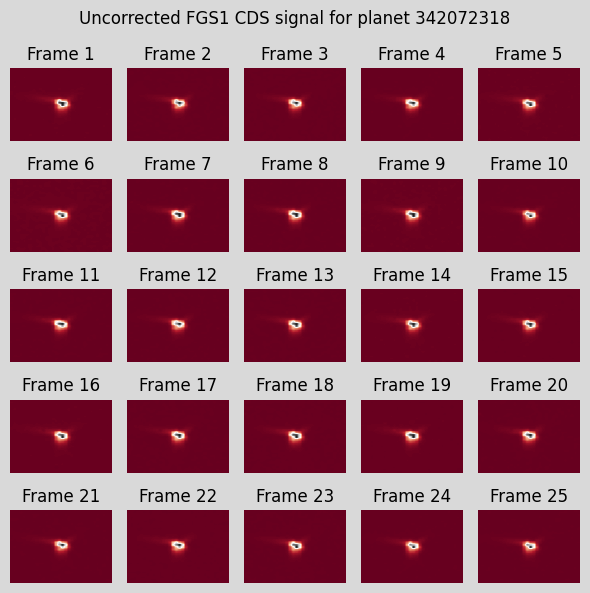

In [17]:
# Plot the first 25 CDS-processed FGS1 frames in a 5x5 grid
n_frames = 25
n_dim = int(n_frames**0.5)
dim = n_dim * 2
fig, axs = plt.subplots(n_dim, n_dim, figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH))
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)
axs = axs.flatten()

fig.suptitle(f'Uncorrected FGS1 CDS signal for planet {config.SAMPLE_PLANET}')

# Display each frame normalized and as a heatmap
for i in range(n_frames):

    frame = fgs_cds_frames[i]        
    # Normalize frame by its mean value for better visualization
    frame = frame.astype(float) / np.mean(frame.astype(float))
    axs[i].imshow(frame, aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
    axs[i].set_title(f'Frame {i+1}')
    axs[i].axis('off')  # Remove all axis elements for cleaner appearance

fig.tight_layout()

# Save the visualization
fig.savefig(
    f'{figures_dir}/01.5.3-uncorrected_FGS1_CDS_sample_frames.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

## 6. Conclusion

OK, so the signal looks much more constant, which is good - but now we get a lot of background noise as well. Now that we have this figured out, we need to do the rest of the corrections as well. Here is the list:

1. Analog-to-Digital Conversion
2. Mask hot/dead pixel
3. Linearity Correction
4. Dark current subtraction
5. Get Correlated Double Sampling (CDS)
6. Flat Field Correction